
# Exp. 3 — Pun Cost Decision Time (Robust Python Notebook)

This notebook reproduces the R analysis for Experiment 3 (Punishment; Decision Time).  
It handles common pitfalls (delimiter differences, string columns, missing packages).

**Pipeline**
1. Load `puntimeE3a.csv` (auto-detect `;` or `,` delimiter).
2. Recode `Condition`: 1 = Observable, 0 = Hidden (matches the R script).
3. Fit OLS: `log(decisionT) ~ Condition`.
4. Compute estimated marginal means (EMMs) with 95% CIs (log scale) + back-transform.
5. Plot bar chart and save outputs.


In [3]:

# Install/Import deps
import sys, subprocess

def ensure(pkg):
    try:
        __import__(pkg)
    except Exception:
        print(f"Installing {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        __import__(pkg)

ensure("pandas")
ensure("numpy")
ensure("matplotlib")
ensure("statsmodels")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from pathlib import Path


In [4]:

# --- Load data ---
# Try local folder first, then /mnt/data. Auto-detect delimiter (; or ,).
CANDIDATES = [Path("puntimeE3a.csv"), Path("/home/limorgu/coding/replications/replication_paper/data/input/puntimeE3a.csv")]
DATA_PATH = next((p for p in CANDIDATES if p.exists()), None)
if DATA_PATH is None:
    raise FileNotFoundError("Place 'puntimeE3a.csv' next to the notebook or at /mnt/data/puntimeE3a.csv.")

# Sniff delimiter
with open(DATA_PATH, "r", encoding="utf-8") as f:
    head = f.read(8192)
sep = ";" if head.count(";") > head.count(",") else ","

df = pd.read_csv(DATA_PATH, sep=sep)
print(f"Loaded {DATA_PATH} with sep='{sep}'. Shape:", df.shape)
print("Columns:", list(df.columns))
df.head()


Loaded /home/limorgu/coding/replications/replication_paper/data/input/puntimeE3a.csv with sep=';'. Shape: (1306, 37)
Columns: ['ID', 'Duration', 'Timer1_First Click', 'Timer1_Last Click', 'Timer1_Page Submit', 'Timer1_Click Count', 'G1comp1', 'G1comp2', 'G1comp3', 'G1comp4', 'Timer2_First Click', 'Timer2_Last Click', 'Timer2_Page Submit', 'Timer2_Click Count', 'G2comp1', 'G2comp2', 'G2comp3', 'Timer3obs_First Click', 'Timer3obs_Last Click', 'Timer3obs_Page Submit', 'Timer3obs_Click Count', 'A2comp4OB', 'punTimer_First Click', 'punTimer_Last Click', 'decisionT', 'punTimer_Click Count', 'punishing', 'Timer3hid_First Click', 'Timer3hid_Last Click', 'Timer3hid_Page Submit', 'Timer3hid_Click Count', 'A2comp4HID', 'return', 'gender', 'age', 'Condition', 'RecordedDate']


,ID,Duration,Timer1_First Click,Timer1_Last Click,Timer1_Page Submit,Timer1_Click Count,G1comp1,G1comp2,G1comp3,G1comp4,...,Timer3hid_First Click,Timer3hid_Last Click,Timer3hid_Page Submit,Timer3hid_Click Count,A2comp4HID,return,gender,age,Condition,RecordedDate
0,1,1901,0.879,29.400,31.369,18,0,1,1,1,...,NaN,NaN,NaN,NaN,NaN,50,1,34,1,16/11/2023 14:05
1,2,1797,264.348,425.772,427.839,4,0,1,1,1,...,208.299,208.299,210.166,1.0,1.0,50,1,53,2,16/11/2023 14:09
2,3,1771,36.399,190.864,192.034,22,1,0,0,1,...,7.463,11.227,11.894,2.0,1.0,60,2,51,2,16/11/2023 14:10
3,4,1710,81.876,128.044,130.026,4,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,50,2,26,1,16/11/2023 14:10
4,5,1706,20.469,127.189,129.322,9,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,50,2,44,1,16/11/2023 14:10


In [5]:

# --- Validate & coerce required columns ---
required = ["Condition", "decisionT"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns: {missing}. Found cols: {list(df.columns)}")

# Coerce numerics safely
df["Condition"] = pd.to_numeric(df["Condition"], errors="coerce")
df["decisionT"] = pd.to_numeric(df["decisionT"], errors="coerce")

# Drop rows with NaNs in key columns
n0 = len(df)
df = df.dropna(subset=["Condition", "decisionT"]).copy()
print(f"Dropped {n0 - len(df)} rows with NA in Condition/decisionT. Kept {len(df)}.")

# Recode Condition: 1=Observable, else 0
df["Condition_rec"] = np.where(df["Condition"] == 1, 1, 0).astype(int)
df["Condition_label"] = np.where(df["Condition_rec"] == 1, "Observable", "Hidden")

# Log-transform decision time (guard against non-positive values)
if (df["decisionT"] <= 0).any():
    raise ValueError("decisionT has non-positive values; log() undefined. Check data.")
df["log_decisionT"] = np.log(df["decisionT"])

df[["Condition","Condition_rec","decisionT","log_decisionT"]].describe(include="all")


Dropped 0 rows with NA in Condition/decisionT. Kept 1306.


,Condition,Condition_rec,decisionT,log_decisionT
count,1306.000000,1306.000000,1306.000000,1306.000000
mean,1.500000,0.500000,10.056173,2.146333
std,0.500192,0.500192,7.119667,0.552467
min,1.000000,0.000000,1.361000,0.308220
25%,1.000000,0.000000,6.223500,1.828332
50%,1.500000,0.500000,8.441000,2.133101
75%,2.000000,1.000000,11.807000,2.468693
max,2.000000,1.000000,109.812000,4.698770


In [6]:

# --- OLS: log(decisionT) ~ Condition ---
model = smf.ols("log_decisionT ~ Condition_rec", data=df).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          log_decisionT   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     7.193
Date:                Mon, 03 Nov 2025   Prob (F-statistic):            0.00741
Time:                        15:16:11   Log-Likelihood:                -1074.1
No. Observations:                1306   AIC:                             2152.
Df Residuals:                    1304   BIC:                             2163.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.1872      0.022    101.408

In [7]:

# --- EMMs (log scale) + back-transform ---
new_df = pd.DataFrame({"Condition_rec":[1,0]})
pred = model.get_prediction(new_df).summary_frame(alpha=0.05)

emm = pd.DataFrame({
    "Condition": ["Observable","Hidden"],
    "emmean_log": pred["mean"].values,
    "lower_log": pred["mean_ci_lower"].values,
    "upper_log": pred["mean_ci_upper"].values
})
emm["emmean_geom"] = np.exp(emm["emmean_log"])
emm["lower_geom"]  = np.exp(emm["lower_log"])
emm["upper_geom"]  = np.exp(emm["upper_log"])

emm.to_csv("E3_emmeans_decision_time.csv", index=False)
emm


,Condition,emmean_log,lower_log,upper_log,emmean_geom,lower_geom,upper_geom
0,Observable,2.105429,2.063116,2.147742,8.210623,7.870455,8.565493
1,Hidden,2.187237,2.144924,2.229550,8.910562,8.541396,9.295685


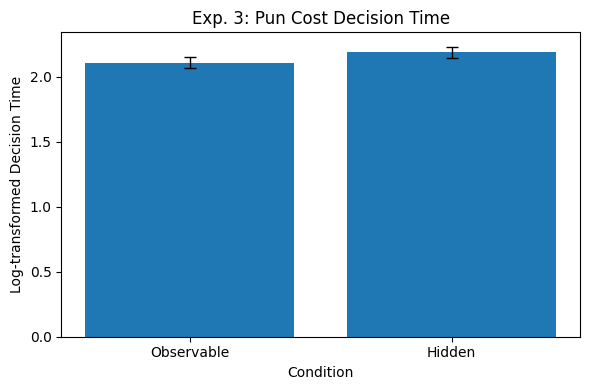

Saved files:
 - E3_pun_cost_decision_time.png
 - E3_emmeans_decision_time.csv


In [8]:

# --- Plot and save ---
x = np.arange(len(emm))
y = emm["emmean_log"].values
yerr = np.vstack([y - emm["lower_log"].values, emm["upper_log"].values - y])

plt.figure(figsize=(6,4))
plt.bar(x, y)  # no specific colors/styles
plt.errorbar(x, y, yerr=yerr, fmt="none", capsize=4, elinewidth=1, ecolor="black")
plt.xticks(x, emm["Condition"].tolist())
plt.ylabel("Log-transformed Decision Time")
plt.xlabel("Condition")
plt.title("Exp. 3: Pun Cost Decision Time")
plt.tight_layout()
plt.savefig("E3_pun_cost_decision_time.png", dpi=200)
plt.show()

print("Saved files:")
print(" - E3_pun_cost_decision_time.png")
print(" - E3_emmeans_decision_time.csv")
